23/11/23 Gait assignment - Yoni Danzig

# 1.Investigating the data:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

file_path = 'Gait.csv'
df = pd.read_csv(file_path)
print(df.head())  # Display the first few rows of the DataFrame

      Acc_V    Gyro_V
0  9.938148 -0.049231
1  9.910905 -0.050852
2  9.895377 -0.049218
3  9.855065 -0.050804
4  9.833067 -0.049230


We are missing a time column but we can add it according to our sampeling rate = 128 Hz

In [5]:
fs = 128     # sampling_rate[Herz]
ts = 1/fs    # [sec]
N = len(df)  # Num of samples = 8510
time_column = pd.Series(range(N)) * ts
df['time'] = time_column

In [6]:
print(df.head())  # Display the first few rows of the DataFrame

      Acc_V    Gyro_V      time
0  9.938148 -0.049231  0.000000
1  9.910905 -0.050852  0.007812
2  9.895377 -0.049218  0.015625
3  9.855065 -0.050804  0.023438
4  9.833067 -0.049230  0.031250


## 1.1Plotting the data in time domain:

In [9]:
def timePlot(df,xlimit=None, showAngularAbs=False):
    # Plotting time versus Acceleration
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'], df['Acc_V'], label='Acceleration')
    plt.xlabel('Time (sec)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.title('Time vs Acceleration')
    if xlimit:
        plt.xlim(xlimit[0], xlimit[1])
    plt.legend()
    plt.show()

    # Plotting time versus Angular Velocity
    plt.figure(figsize=(10, 6))
    if showAngularAbs:
        plt.plot(df['time'], abs(df['Gyro_V']), label='Absolut Angular Velocity')
    else:
        plt.plot(df['time'], df['Gyro_V'], label='Angular Velocity')
    plt.xlabel('Time (sec)')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.title('Time vs Angular Velocity')
    if xlimit:
        plt.xlim(xlimit[0], xlimit[1])
    plt.legend()
    plt.show()

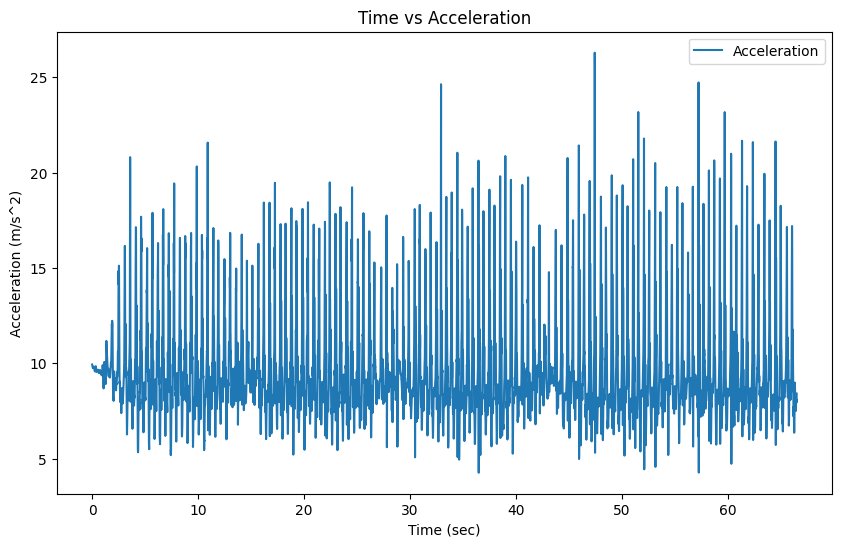

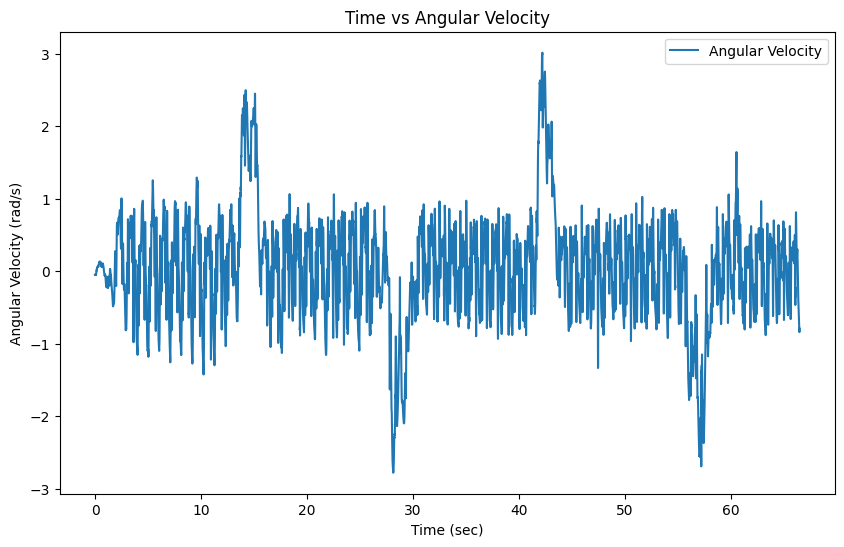

In [10]:
timePlot(df)

We can clearly see that the angular velocity graph is presenting the turn around of the person (clockwise or anti-clockwise) 
And the acceleration graph presents the walking process

closer look - Lets see only 10 seconds of the signal:

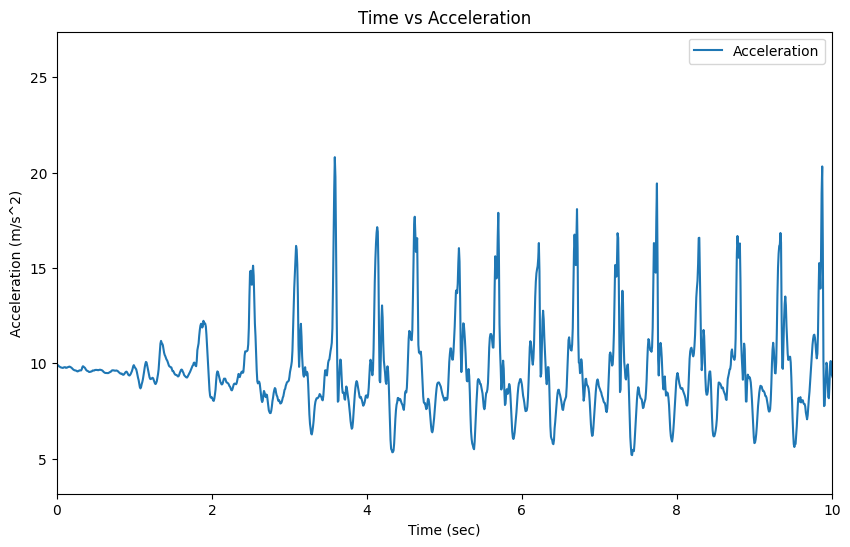

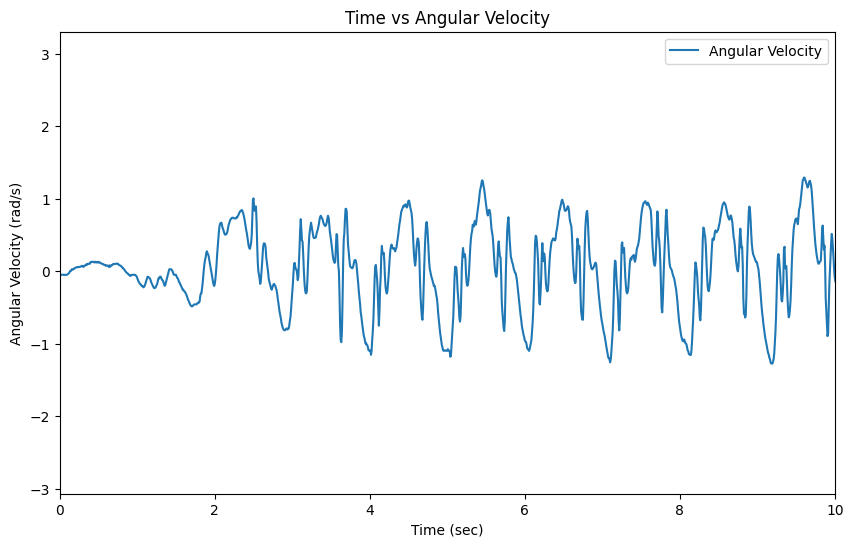

In [13]:
timePlot(df, xlimit = [0,10])

## 1.2 Signals in the frequency domain:

In [14]:
#Function creation for fft:
def fft_graph(fs, df, xlimit = None, ylimit = None):
    N_samp = len(df)                          #Number of samples
    fm = fs / 2                               #Maximun Fequency that can be sampled
    freq_interval = fs / N_samp               #Frequenct Interval = df
    f = np.arange(-fm, fm, freq_interval)  # Frequency vector for FFTshift
    Y_f = np.fft.fftshift(np.fft.fft(df))
    plt.plot(f, np.abs(Y_f) / N_samp)
    plt.grid(True)
    if xlimit:
        plt.xlim(xlimit[0], xlimit[1])
    if ylimit:
        plt.ylim(ylimit[0], ylimit[1])
    plt.xlabel('f[Hz]')
    plt.ylabel('|Y(f)|/N')
    plt.show()
    # Find peaks above the threshold
    #print(f[find_peaks(np.abs(Y_f) / N_samp, height=0.5)[0]])

## 1.2.1 Plotting the FFT for the Acceleration graph (steps):

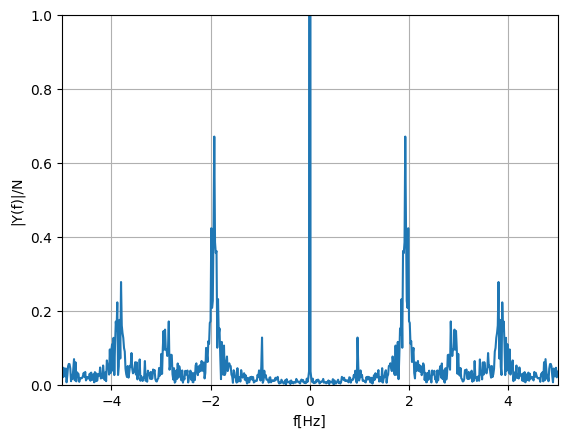

In [16]:
fft_graph(fs = fs, df = df['Acc_V'], xlimit = [-5,5], ylimit = [0,1])

## 1.2.2 Plotting the FFT For the Gyro Angular Velocity graph (turns):

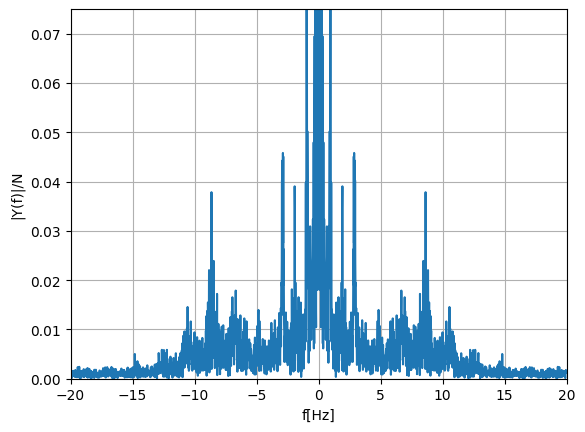

In [18]:
fft_graph(fs = fs, df = df['Gyro_V'], xlimit = [-20,20], ylimit = [0,0.075])

We can see from the graph above that the freqency of the walking is circa 1.9[Hz]. one step time is 1/f = 0.52[sec].
time of the recording is 66.48 seconds means circa 128 steps in total

# 2. Cleaning the data
# 2.1 Low-pass filtering the gyro signal:

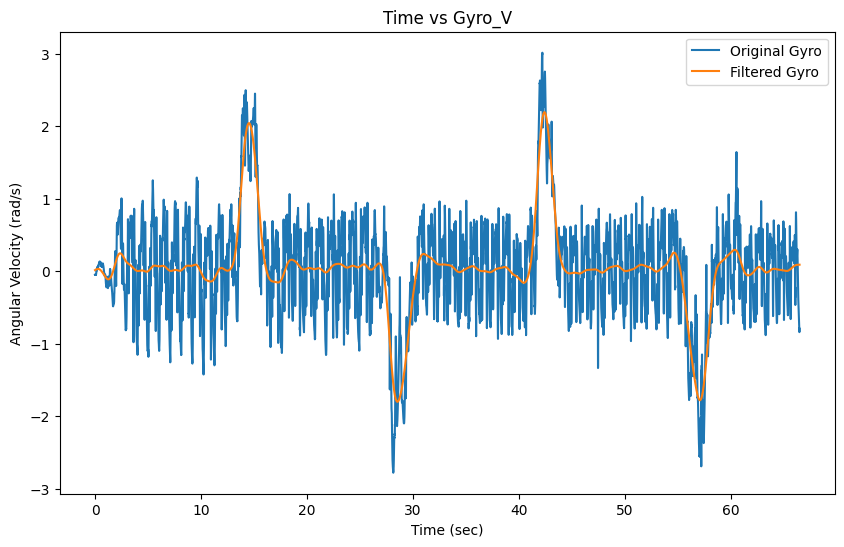

In [19]:
from scipy.signal import butter, filtfilt

# Define the low-pass filter parameters
cutoff_frequency = 0.5
order = 3

# Design the Butterworth filter
b, a = butter(order, cutoff_frequency, btype='low', analog=False, fs=fs, output='ba')

# Apply the filter to the acceleration data
gyro_filtered = filtfilt(b, a, df['Gyro_V'])

# Plotting time versus Acceleration (filtered)
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Gyro_V'], label='Original Gyro')
plt.plot(df['time'], gyro_filtered, label='Filtered Gyro')
plt.xlabel('Time (sec)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Time vs Gyro_V')
plt.legend()
plt.show()

Filtering looks good... let's add it to our dataframe:

In [20]:
df['Gyro_V_filtered'] = gyro_filtered

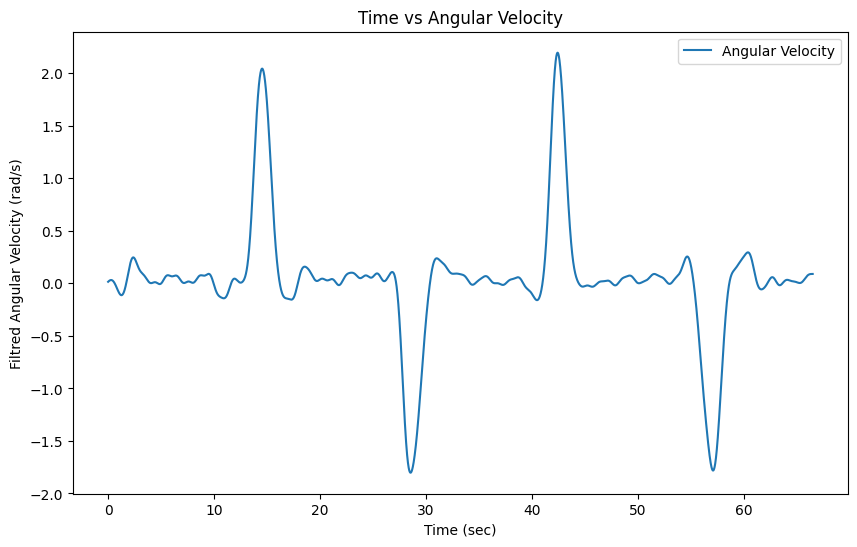

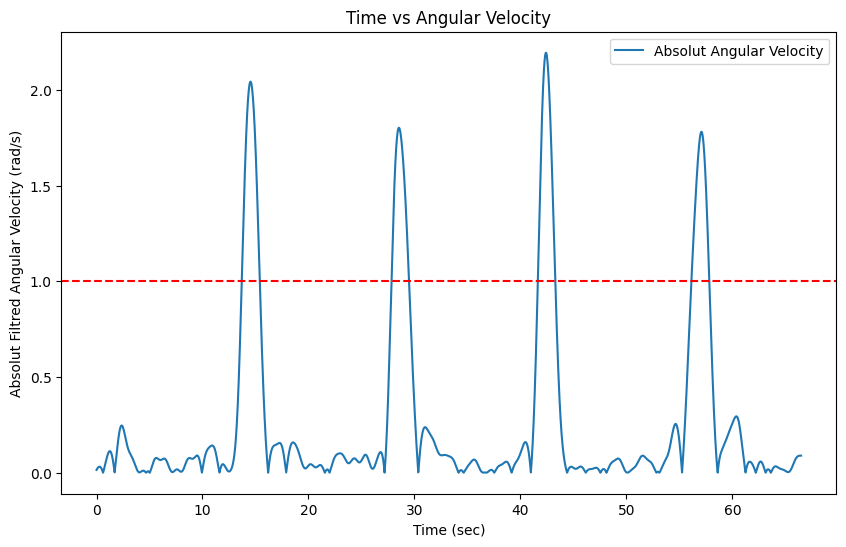

In [21]:
# Plotting time versus filtred Angular Velocity
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Gyro_V_filtered'], label='Angular Velocity')
plt.xlabel('Time (sec)')
plt.ylabel('Filtred Angular Velocity (rad/s)')
plt.title('Time vs Angular Velocity')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['time'], abs(df['Gyro_V_filtered']), label='Absolut Angular Velocity')
plt.xlabel('Time (sec)')
plt.ylabel('Absolut Filtred Angular Velocity (rad/s)')
plt.title('Time vs Angular Velocity')
# Add a red dotted line at y=1
plt.axhline(y=1, color='red', linestyle='--')
plt.legend()
plt.show()

We can use the absolut signal since we don't need to identify if the turns are clockwise or not. setting threshold for 1rad/s is a good idea for turn identification.

# 2.2 Identifying the turns by the gyro signal (After filtering):

In [22]:
from scipy.signal import find_peaks
# Define a threshold
threshold = 1

# Find peaks above the threshold
peaks_index = find_peaks(abs(df['Gyro_V_filtered']), height=threshold)[0]
peaks_index

array([1860, 3652, 5428, 7306], dtype=int64)

In [26]:
turns_time = [df['time'][i] for i in peaks_index]

In [27]:
print(turns_time)

[14.53125, 28.53125, 42.40625, 57.078125]


The turning around even occurs on t ~= 14.53125, 28.53125, 42.40625, 57.078125 seconds.

# 2.3 Counting the steps from investigating time-domain accelaration:

## 2.3.1 Low-pass filtering of the accelerometer signal:

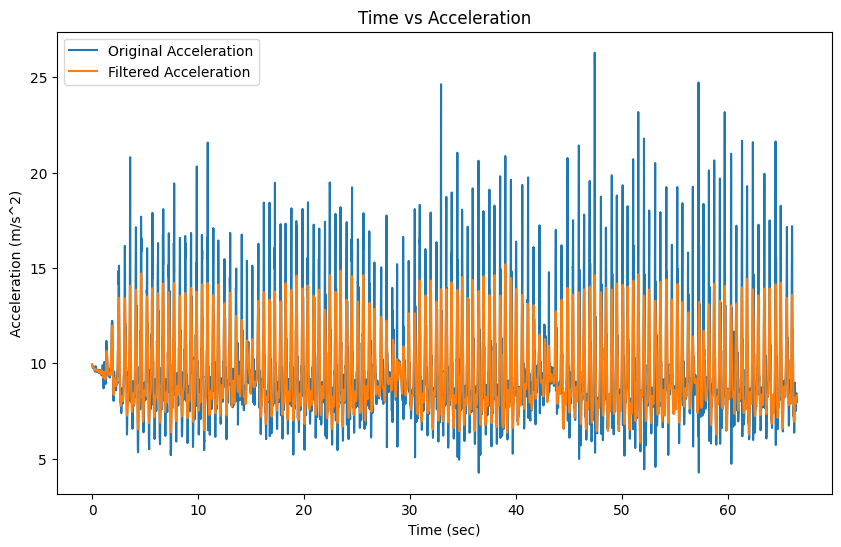

In [29]:
# Define the low-pass filter parameters
cutoff_frequency = 5
order = 4

# Design the Butterworth filter
b, a = butter(order, cutoff_frequency, btype='low', analog=False, fs=fs, output='ba')

# Apply the filter to the acceleration data
acc_filtered = filtfilt(b, a, df['Acc_V'])

# Plotting time versus Acceleration (filtered)
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Acc_V'], label='Original Acceleration')
plt.plot(df['time'], acc_filtered, label='Filtered Acceleration')
plt.xlabel('Time (sec)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Time vs Acceleration')
#plt.xlim(20, 25)
plt.legend()
plt.show()

In [30]:
#Looks good... let's add it to the dataframe:

In [31]:
df['Acc_V_filtered'] = acc_filtered

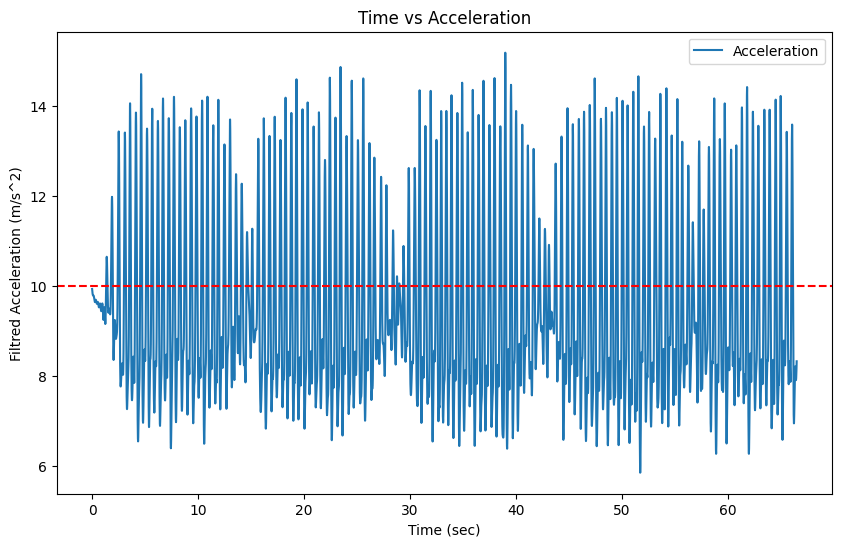

In [32]:
# Plotting time versus filtred Acceleration
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Acc_V_filtered'], label='Acceleration')
plt.xlabel('Time (sec)')
plt.ylabel('Filtred Acceleration (m/s^2)')
plt.title('Time vs Acceleration')
# Add a red dotted line at y=1
plt.axhline(y=10, color='red', linestyle='--')
plt.legend()
plt.show()

In [33]:
# Counting the steps:

In [34]:
# Define a threshold
threshold = 10

# Find peaks above the threshold
peaks_index = find_peaks(abs(df['Acc_V_filtered']), height=threshold)[0]

In [35]:
#counting the results:
len(peaks_index)

126

We counted 126 steps which is quite similar to the result above from the FFT calculation (128)

# 3. Autocorrelation of the Acceleration data

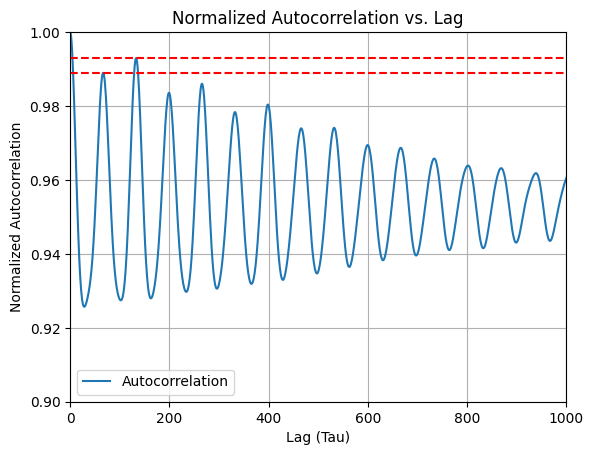

In [37]:
#Showing the right hand of auto-correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with 'time' and 'Acc_V_filtered' columns
# Create a Pandas Series from the 'Acc_V_filtered' column
signal = df['Acc_V_filtered']

# Calculate the length of the signal
n = len(signal)

# Initialize an empty list to store unbiased autocorrelation values
autocorrelation_unbiased = []

# Calculate unbiased autocorrelation for all lags (taus)
for lag in range(0, n):
    # Calculate the autocorrelation for the current lag
    autocorr = np.correlate(signal, signal.shift(lag).fillna(0), mode='valid')[0] / (n - lag)
    autocorrelation_unbiased.append(autocorr)

# Normalize the autocorrelation values
autocorrelation_normalized = [corr / autocorrelation_unbiased[0] for corr in autocorrelation_unbiased]

# Create a Pandas DataFrame to store the results
autocorr_df = pd.DataFrame({'Lag': range(n), 'Autocorrelation': autocorrelation_normalized})

# Plot the tau (lags) versus the normalized autocorrelation
autocorr_df.plot(x='Lag', y='Autocorrelation', kind='line', title='Normalized Autocorrelation vs. Lag')
plt.xlabel('Lag (Tau)')
plt.ylabel('Normalized Autocorrelation')
plt.grid(True)
plt.axhline(y=0.9889628764612806, color='red', linestyle='--')
plt.axhline(y=0.9929510914585223, color='red', linestyle='--')
plt.xlim(0,1000)
plt.ylim(0.9,1)
plt.show()

In [38]:
#Finding peaks values.
# Define a threshold
threshold = 0.98

# Find peaks above the threshold
peaks_value = find_peaks(autocorr_df['Autocorrelation'][0:180], height=threshold)[1]['peak_heights']

In [39]:
AD1 = peaks_value[0].round(4)
AD2 = peaks_value[1].round(4)
Step_symmetry = AD1/AD2
print("Step regularity = {0}, Stride regularity = {1}, Step symmetry = {2}".format(AD1,AD2,Step_symmetry))

Step regularity = 0.989, Stride regularity = 0.993, Step symmetry = 0.9959718026183283


In [ ]:
# Matlab approach:
% Load the CSV file into a table
data = readtable('Gait_full.csv');

% Extract the 'Acc_V_filtered' column
acc_filtered = data.Acc_V_filtered;

% Calculate the unbiased and normalized autocorrelation using xcov
[autocorr_values, lags] = xcov(acc_filtered, 'coeff');

% Plot the autocorrelation
figure;
plot(lags, autocorr_values);
xlim([0 1000])
title('Autocorrelation of Acc\_V\_filtered');
xlabel('Lags');
ylabel('Autocorrelation Coefficient');

% Display the plot
grid on;

Image:

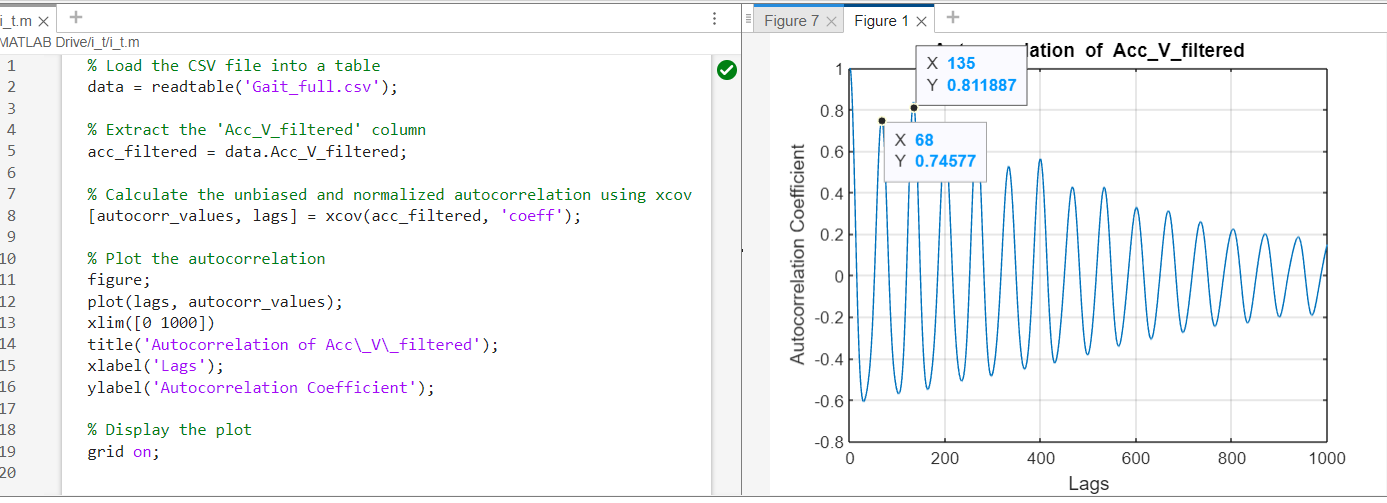

The difference between the first and second peak (more accurate - odd/even peaks) can help you to identify walking problems such asymetric steps(small&large steps) or low regulatory (limping). as the higher the values the goos is the walking. very important is to compate AD1&AD2 by Step symmetry which should be 1 for good and symetric walking.